This notebook shows that how random noise embedder, impulse embedder works with different number of samples when embedding dimension is large enough.

In [39]:
from pylab import *
from skimage.color import rgb2gray
from skimage.transform import rescale,resize
from torch.autograd import Variable
import torch, time,os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy


# Set the CUDA flag
cuda_flag = True
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
criterion = torch.nn.MSELoss()
epochs = 4000
lr = 1e-4

sample_N = 512
sample_ds = [1,2,3,4,6,8,11,16]
embedding_dimension = 10000

Nd = len(sample_ds)
N_test = 10
N_repeat = 10

#kk = torch.randint(512,(N_test,))
kk = [158, 329,  47, 344, 257, 410, 426, 199, 426, 295]
#kk = [ 88, 269, 409,  59, 245, 382, 277, 362,  23, 308, 504, 448, 411, 304, 365, 200,  92, 350, 405,  77]

losses_ = np.zeros((Nd,N_test,N_repeat,epochs))
sr_ = np.zeros((Nd,N_test,N_repeat))
trn_psnr_ = np.zeros((Nd,N_test,N_repeat,epochs))
tst_psnr_ = np.zeros((Nd,N_test,N_repeat,epochs))

file_path = 'Final_2one/'

In [2]:
rgb = imread('4.2.07.tiff');im = rgb2gray(rgb);
signal = torch.from_numpy(im).type(torch.FloatTensor)

In [3]:
width = 256

# Here define the MLP
class SLP(nn.Module):
    def __init__(self,input_dim):
        super(SLP, self).__init__()
        self.fco = nn.Linear(input_dim, 1)
    def forward(self, x):
        out = self.fco(x)
        return out
    def name(self):
        return "SLP"

In [4]:
def srank_func(X):
    # Get the SVD
    (u,s,v) = torch.svd(X)
    sr = (s*s).sum()/s[0]/s[0]
    return sr

def psnr_func(x,y):
    diff = x - y
    err = (diff*diff).flatten().mean().log10()
    return -10*err

def impulse_embedding(x, b, s=1e-4):
    emb = (abs(x-b)<s).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()

def square_embedding(x, b, f=1):
    emb = (torch.sin(2.*np.pi*f*(x-b))>0).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()

def shift_embedding(x, c):
    all_emb = scipy.linalg.circulant(c)
    idx = (x*all_emb.shape[0]).int().squeeze()
    emb = torch.from_numpy(all_emb[idx]).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()
    

def norm_func(x):
    # Flatten the data 
    #x = x.flatten(1,3)
    
    # Normalize for gain and bias
    y = x-x.mean(1).unsqueeze(-1)
    y = x/x.norm(dim=1).unsqueeze(-1)    
    return y

# Impulse embedding

In [5]:
all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

c = np.zeros((embedding_dimension,))
c[0] = 1
c = c/np.linalg.norm(c)

for i in range(Nd):
    sample_d = sample_ds[i]

    train_data = shift_embedding(all_data[::2*sample_d],c)
    test_data = shift_embedding(all_data[sample_d::2*sample_d],c)

    # Calculate the input stable rank
    sr_[i] = srank_func(train_data)


    for j in range(N_test):
        start_time = time.time()
        
        
        # Prepare the data
        all_target = signal[kk[j]].reshape(-1,1)
        train_label = all_target[::2*sample_d]
        test_label = all_target[sample_d::2*sample_d]
        
        xt, yt = train_data.cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = test_data.cuda(),test_label.cuda()
        
        
        for k in range(N_repeat):
            # Initialize classification model to learn
            model = SLP(embedding_dimension).cuda()
            # Set the optimization
            optimizer = optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999),weight_decay=1e-8)
            

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                out = model(xt)
                loss = criterion(out, yt)

                loss.backward()
                losses_[i,j,k,epoch] = loss.item()
                optimizer.step()

                model.eval()
                trn_psnr_[i,j,k,epoch] = psnr_func(model(xt),yt)
                tst_psnr_[i,j,k,epoch] = psnr_func(model(xts),yts)


            print("==>>> N: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                    % (i,j, np.mean(trn_psnr_[i,j,k,-100:]),np.mean(tst_psnr_[i,j,k,-100:]),time.time() - start_time))

==>>> N: 0, F: 0, train psnr: 123.317--- , test psnr: 10.6905--- , time: 13.7508 seconds ---
==>>> N: 0, F: 0, train psnr: 123.284--- , test psnr: 10.6843--- , time: 20.6273 seconds ---
==>>> N: 0, F: 0, train psnr: 122.983--- , test psnr: 10.5398--- , time: 27.5644 seconds ---
==>>> N: 0, F: 0, train psnr: 123.185--- , test psnr: 10.7061--- , time: 34.5919 seconds ---
==>>> N: 0, F: 0, train psnr: 123.262--- , test psnr: 10.708--- , time: 41.4767 seconds ---
==>>> N: 0, F: 0, train psnr: 123.047--- , test psnr: 10.5113--- , time: 48.5085 seconds ---
==>>> N: 0, F: 0, train psnr: 123.319--- , test psnr: 10.6845--- , time: 55.4044 seconds ---
==>>> N: 0, F: 0, train psnr: 123.104--- , test psnr: 10.6111--- , time: 62.361 seconds ---
==>>> N: 0, F: 0, train psnr: 122.93--- , test psnr: 10.5241--- , time: 69.3007 seconds ---
==>>> N: 0, F: 0, train psnr: 122.931--- , test psnr: 10.5585--- , time: 76.2198 seconds ---
==>>> N: 0, F: 1, train psnr: 126.884--- , test psnr: 11.3291--- , time: 

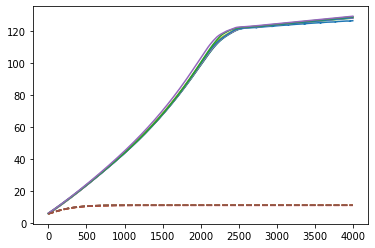

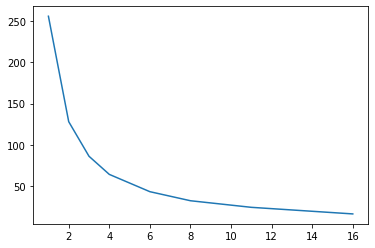

In [6]:
figure()
for i in range(Nd):
    plot(np.mean(trn_psnr_[i,:,:],(0,1)))
    plot(np.mean(tst_psnr_[i,:,:],(0,1)),'--')

figure()
plot(sample_ds,np.mean(sr_,(1,2)))

In [7]:
file_name = 'impulse'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)

# random noise embedding

In [8]:
all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)



for i in range(Nd):
    sample_d = sample_ds[i]

    for j in range(N_test):
        start_time = time.time()
        
        
        # Prepare the data
        all_target = signal[kk[j]].reshape(-1,1)
        train_label = all_target[::2*sample_d]
        test_label = all_target[sample_d::2*sample_d]
        
        
        
        
        for k in range(N_repeat):
            
            c = np.random.randn(embedding_dimension)
            c = c/np.linalg.norm(c)
            
            train_data = shift_embedding(all_data[::2*sample_d],c)
            test_data = shift_embedding(all_data[sample_d::2*sample_d],c)
            
            xt, yt = train_data.cuda(),train_label.cuda()
            xt, yt = Variable(xt), Variable(yt)

            xts, yts = test_data.cuda(),test_label.cuda()

            # Calculate the input stable rank
            sr_[i,j,k] = srank_func(train_data)

            
            # Initialize classification model to learn
            model = SLP(embedding_dimension).cuda()
            # Set the optimization
            optimizer = optim.Adam(model.parameters(), 1e-4, betas=(0.9, 0.999),weight_decay=1e-8)
            

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                out = model(xt)
                loss = criterion(out, yt)

                loss.backward()
                losses_[i,j,k,epoch] = loss.item()
                optimizer.step()

                model.eval()
                trn_psnr_[i,j,k,epoch] = psnr_func(model(xt),yt)
                tst_psnr_[i,j,k,epoch] = psnr_func(model(xts),yts)


            print("==>>> N: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                    % (i,j, np.mean(trn_psnr_[i,j,k,-100:]),np.mean(tst_psnr_[i,j,k,-100:]),time.time() - start_time))

==>>> N: 0, F: 0, train psnr: 112.112--- , test psnr: 5.68134--- , time: 8.35212 seconds ---
==>>> N: 0, F: 0, train psnr: 113.256--- , test psnr: 7.89045--- , time: 16.8279 seconds ---
==>>> N: 0, F: 0, train psnr: 112.069--- , test psnr: 5.35961--- , time: 25.2656 seconds ---
==>>> N: 0, F: 0, train psnr: 112.57--- , test psnr: 5.98385--- , time: 33.7491 seconds ---
==>>> N: 0, F: 0, train psnr: 112.522--- , test psnr: 7.04619--- , time: 42.245 seconds ---
==>>> N: 0, F: 0, train psnr: 112.739--- , test psnr: 5.90551--- , time: 50.8406 seconds ---
==>>> N: 0, F: 0, train psnr: 112.048--- , test psnr: 8.65034--- , time: 59.5991 seconds ---
==>>> N: 0, F: 0, train psnr: 112.96--- , test psnr: 8.33021--- , time: 68.4682 seconds ---
==>>> N: 0, F: 0, train psnr: 112.618--- , test psnr: 5.43367--- , time: 77.0771 seconds ---
==>>> N: 0, F: 0, train psnr: 112.901--- , test psnr: 5.07905--- , time: 86.0902 seconds ---
==>>> N: 0, F: 1, train psnr: 113.661--- , test psnr: 5.38549--- , time: 

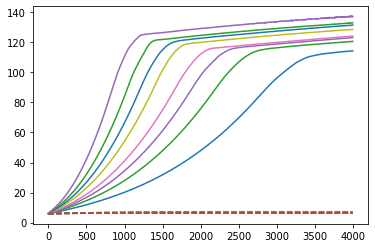

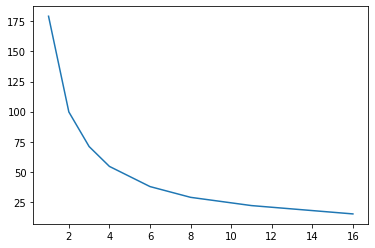

In [9]:
figure()
for i in range(Nd):
    plot(np.mean(trn_psnr_[i,:,:],(0,1)))
    plot(np.mean(tst_psnr_[i,:,:],(0,1)),'--')

figure()
plot(sample_ds,np.mean(sr_,(1,2)))

In [10]:
file_name = 'random'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)

In [30]:
signal = torch.randn((512,512)).type(torch.FloatTensor)

In [45]:
all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

c = np.zeros((embedding_dimension,))
c[0] = 1
c = c/np.linalg.norm(c)

for i in range(Nd):
    sample_d = sample_ds[i]

    train_data = shift_embedding(all_data[::2*sample_d],c)
    test_data = shift_embedding(all_data[sample_d::2*sample_d],c)

    # Calculate the input stable rank
    sr_[i] = srank_func(train_data)


    for j in range(N_test):
        start_time = time.time()
        
        
        # Prepare the data
        all_target = signal[kk[j]].reshape(-1,1)
        train_label = all_target[::2*sample_d]
        test_label = all_target[sample_d::2*sample_d]
        
        xt, yt = train_data.cuda(),train_label.cuda()
        xt, yt = Variable(xt), Variable(yt)

        xts, yts = test_data.cuda(),test_label.cuda()
        
        
        for k in range(N_repeat):
            # Initialize classification model to learn
            model = SLP(embedding_dimension).cuda()
            # Set the optimization
            optimizer = optim.Adam(model.parameters(), 3e-3, betas=(0.9, 0.999),weight_decay=1e-8)
            

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                out = model(xt)
                loss = criterion(out, yt)

                loss.backward()
                losses_[i,j,k,epoch] = loss.item()
                optimizer.step()

                model.eval()
                trn_psnr_[i,j,k,epoch] = psnr_func(model(xt),yt)
                tst_psnr_[i,j,k,epoch] = psnr_func(model(xts),yts)


            print("==>>> N: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                    % (i,j, np.mean(trn_psnr_[i,j,k,-100:]),np.mean(tst_psnr_[i,j,k,-100:]),time.time() - start_time))

==>>> N: 0, F: 0, train psnr: 111.072--- , test psnr: -0.726219--- , time: 6.86672 seconds ---
==>>> N: 0, F: 0, train psnr: 114.558--- , test psnr: -0.726306--- , time: 13.5811 seconds ---
==>>> N: 0, F: 0, train psnr: 110.99--- , test psnr: -0.727415--- , time: 20.2065 seconds ---
==>>> N: 0, F: 0, train psnr: 89.6616--- , test psnr: -0.72711--- , time: 26.8519 seconds ---
==>>> N: 0, F: 0, train psnr: 111.245--- , test psnr: -0.727188--- , time: 33.4582 seconds ---
==>>> N: 0, F: 0, train psnr: 111.009--- , test psnr: -0.725744--- , time: 40.0203 seconds ---
==>>> N: 0, F: 0, train psnr: 111.043--- , test psnr: -0.726535--- , time: 46.9051 seconds ---
==>>> N: 0, F: 0, train psnr: 103.112--- , test psnr: -0.72755--- , time: 53.6459 seconds ---
==>>> N: 0, F: 0, train psnr: 94.2303--- , test psnr: -0.725982--- , time: 60.3201 seconds ---
==>>> N: 0, F: 0, train psnr: 111.022--- , test psnr: -0.727869--- , time: 67.0524 seconds ---
==>>> N: 0, F: 1, train psnr: 111.219--- , test psnr:

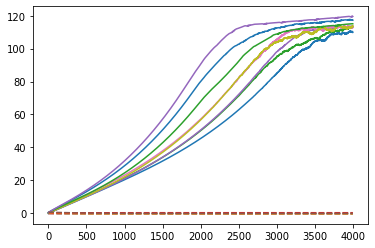

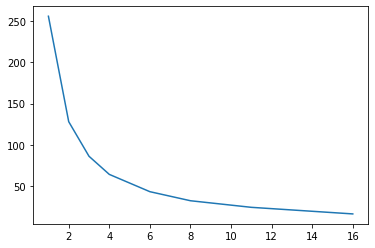

In [46]:
figure()
for i in range(Nd):
    plot(np.mean(trn_psnr_[i,:,:],(0,1)))
    plot(np.mean(tst_psnr_[i,:,:],(0,1)),'--')

figure()
plot(sample_ds,np.mean(sr_,(1,2)))

In [47]:
file_name = 'impulse_random'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)

In [48]:
all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)



for i in range(Nd):
    sample_d = sample_ds[i]

    for j in range(N_test):
        start_time = time.time()
        
        
        # Prepare the data
        all_target = signal[kk[j]].reshape(-1,1)
        train_label = all_target[::2*sample_d]
        test_label = all_target[sample_d::2*sample_d]
        
        
        
        
        for k in range(N_repeat):
            
            c = np.random.randn(embedding_dimension)
            c = c/np.linalg.norm(c)
            
            train_data = shift_embedding(all_data[::2*sample_d],c)
            test_data = shift_embedding(all_data[sample_d::2*sample_d],c)
            
            xt, yt = train_data.cuda(),train_label.cuda()
            xt, yt = Variable(xt), Variable(yt)

            xts, yts = test_data.cuda(),test_label.cuda()

            # Calculate the input stable rank
            sr_[i,j,k] = srank_func(train_data)

            
            # Initialize classification model to learn
            model = SLP(embedding_dimension).cuda()
            # Set the optimization
            optimizer = optim.Adam(model.parameters(), 2e-4, betas=(0.9, 0.999),weight_decay=1e-8)
            

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                out = model(xt)
                loss = criterion(out, yt)

                loss.backward()
                losses_[i,j,k,epoch] = loss.item()
                optimizer.step()

                model.eval()
                trn_psnr_[i,j,k,epoch] = psnr_func(model(xt),yt)
                tst_psnr_[i,j,k,epoch] = psnr_func(model(xts),yts)


            print("==>>> N: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                    % (i,j, np.mean(trn_psnr_[i,j,k,-100:]),np.mean(tst_psnr_[i,j,k,-100:]),time.time() - start_time))

==>>> N: 0, F: 0, train psnr: 106.883--- , test psnr: -0.68656--- , time: 7.81973 seconds ---
==>>> N: 0, F: 0, train psnr: 106.932--- , test psnr: -0.992907--- , time: 15.5915 seconds ---
==>>> N: 0, F: 0, train psnr: 107.099--- , test psnr: -0.809556--- , time: 23.3582 seconds ---
==>>> N: 0, F: 0, train psnr: 107.077--- , test psnr: -0.657367--- , time: 31.1497 seconds ---
==>>> N: 0, F: 0, train psnr: 106.859--- , test psnr: -0.693728--- , time: 38.826 seconds ---
==>>> N: 0, F: 0, train psnr: 107.006--- , test psnr: -0.804995--- , time: 46.5 seconds ---
==>>> N: 0, F: 0, train psnr: 107.115--- , test psnr: -0.76968--- , time: 54.1829 seconds ---
==>>> N: 0, F: 0, train psnr: 106.786--- , test psnr: -0.831906--- , time: 62.4368 seconds ---
==>>> N: 0, F: 0, train psnr: 107.078--- , test psnr: -0.605835--- , time: 70.2031 seconds ---
==>>> N: 0, F: 0, train psnr: 107.079--- , test psnr: -0.991752--- , time: 77.7424 seconds ---
==>>> N: 0, F: 1, train psnr: 105.991--- , test psnr: 0.

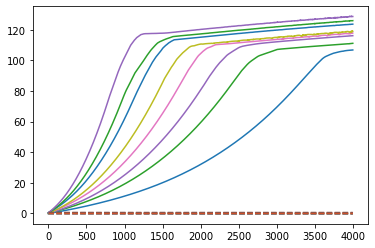

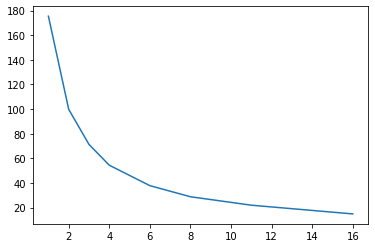

In [49]:
figure()
for i in range(Nd):
    plot(np.mean(trn_psnr_[i,:,:],(0,1)))
    plot(np.mean(tst_psnr_[i,:,:],(0,1)),'--')

figure()
plot(sample_ds,np.mean(sr_,(1,2)))

In [50]:
file_name = 'random_random'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)